# Quantitative Spatial Economics 

## Tutorial Topic 4: Rewrite Ahlfeldt & Barr (2022)

Humboldt University Berlin & Berlin School of Economics

Authors:
[Dominik Bursy](dominik.bursy@icloud.com), 
[Lars Felder](lars.felder@fu-berlin.de), 
[Kate Bablyak](kateryna.bablyak@student.hu-berlin.de), 
[Marlon Krippendorf](marlon.krippendorf@fu-berlin.de)


Last Update: May 2025

---

Ahlfeldt, Gabriel M., and Jason Barr. ‘The Economics of Skyscrapers: A Synthesis’. Journal of Urban Economics 129 (May 2022): 103419. https://doi.org/10.1016/j.jue.2021.103419

---

## Import Packages <a class="anchor" id="packages"></a>

In [139]:
from pathlib import Path
import os
# Traveltime x Travelcost
import numpy as np
import pandas as pd
import geopandas as gpd
from tabulate import tabulate

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import statsmodels.api as sm
from linearmodels import PanelOLS 
# from tabulate import tabulate

import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

## Document Options
savefigures = False
# pd.set_option('display.max_columns', None)

In [140]:
## Set Root Directory
ROOT_FOLDER = str(Path().absolute().parent)
print(ROOT_FOLDER)

/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration


---

## Generate artificial data set

In [141]:
## 1. Intialize Dataframe

def initialize_dataframe(large = False): # User-specified city size Set to True for large city
    # City layout and spatial distance
    if large:
        # obs = 20001
        # x = np.arange(-10000, 10001).reshape(-1, 1)
        df = pd.DataFrame({'x': np.arange(-10000, 10001)})
    else:
        # obs = 10001
        # x = np.arange(-5000, 5001).reshape(-1, 1)
        df = pd.DataFrame({'x': np.arange(-5000, 5001)})

    df['D'] = np.abs(df['x']) / 100  # Distance in km
    df['x'] /= 100          # Convert to km

    # Starting values
    df['y'] = 2.5
    df['L'] = 1000000

    # Generate placeholders for objects to be set by user 
    df['r_a'] = 100
    df['a_x_C'] = np.nan
    df['a_x_R'] = np.nan

    # Generate placeholders for objects to be solved
    df['a_rand_C'] = 1 # Location specific component in production amenity that can be used to generate fuzzy height gradients (not relevant when working with stylized cities)
    df['a_rand_R'] = 1 # Location specific component in residential amenity that can be used to generate fuzzy height gradients (not relevant when working with stylized cities)
    df['A_tilde_x_C'] = np.nan # Compositive productivity shifter
    df['A_tilde_x_R'] = np.nan # Compositive amenity shifter
    df['r_x_C'] = np.nan # Commercial land rent
    df['r_x_R'] = np.nan # Residential land rent
    df['U'] = np.nan # Auxilliary variable for land use category
    df['S_star_x_C'] = np.nan # Profit-maximizing commerical height
    df['S_star_x_R'] = np.nan # Profit-maximizing residential height
    df['S_x_C'] = np.nan # Realized commercial height
    df['S_x_R'] = np.nan # Realized residential height
    df['S_x'] = np.nan # Height
    df['p_bar_x_C'] = np.nan # Commericial horizontal bid rent
    df['p_bar_x_R'] = np.nan # Residential horizontal bid rent
    df['L_x_C'] = np.nan        # Labour input
    df['f_bar_x_R'] = np.nan    # Residential floor space demand per capita
    df['n_x'] = np.nan          # Labour supply
    df['URBAN'] = np.nan        # Auxiliary idicator for urban user
    df['COM'] = np.nan          # Auxiliary indicator for commerical use
    df['SHADE'] = np.nan        # Auxiliary indicator used in graphs
    df['SHADEU'] = np.nan       # Auxiliary indicator used in graphs
    return df

In [142]:
## 2. Export Initiale Dataframe 
# os.makedirs(f'data/AB2022', exist_ok=True)
# initialize_dataframe(large = False).to_csv(f'data/AB2022/simulation_base.csv')

---

## Define programmes for solving the model: SOVLER

In [143]:
def SOLVER(df, params):
    '''
    '''
    df = df.copy()
    params = params.copy()
    
    ### Clear any pre-existing value
    columns = ['A_tilde_x_C', 'A_tilde_x_R', 'a_x_C', 'a_x_R', 'r_x_C', 'r_x_R', 'U', 'S_x_C', 'S_x_R', 'p_bar_x_C', 'p_bar_x_R', 'L_x_C', 'f_bar_x_R', 'n_x']
    df[columns] = np.nan

    # Compute Amenity and floor space shifters derived on p. 7
    df['A_tilde_x_C'] = params['a_bar_C'] * df['a_rand_C'] * np.exp(-params['tau_C'] * df['D']) * (df['L'] ** params['beta_C']) # Commercial production amenity shifter
    df['A_tilde_x_R'] = params['a_bar_R'] * df['a_rand_R'] * np.exp(-params['tau_R'] * df['D']) * (df['L'] ** params['beta_R']) # Residential amenity shifter
    df['a_x_C'] = df['A_tilde_x_C'] ** (1 / (1 - params['alpha_C'])) * (df['y'] ** (params['alpha_C'] / (params['alpha_C'] - 1))) # Commercial floor space shifter
    df['a_x_R'] = df['A_tilde_x_R'] ** (1 / (1 - params['alpha_R'])) * (df['y'] ** (1 / (1 - params['alpha_R']))) # Residential floor space shifter

    ## Land rent according to Eq. (7)
    df['r_x_C'] = df['a_x_C'] / (1 + params['omega_C']) * (df['a_x_C'] / (params['c_C'] * (1 + params['theta_C'])))**((1 + params['omega_C']) / (params['theta_C'] - params['omega_C'])) \
            - params['c_C'] * (df['a_x_C'] / (params['c_C'] * (1 + params['theta_C'])))**((1 + params['theta_C']) / (params['theta_C'] - params['omega_C']))

    df['r_x_R'] = df['a_x_R'] / (1 + params['omega_R']) * (df['a_x_R'] / (params['c_R'] * (1 + params['theta_R'])))**((1 + params['omega_R']) / (params['theta_R'] - params['omega_R'])) \
        - params['c_R'] * (df['a_x_R'] / (params['c_R'] * (1 + params['theta_R'])))**((1 + params['theta_R']) / (params['theta_R'] - params['omega_R']))
        
    ## Define land use
    df['U'] = np.nan # Clear any pre-existing value
    df.loc[(df['r_a'] > df['r_x_C']) & (df['r_a'] > df['r_x_R']), 'U'] = 3      # Agrictultural land rent is highest
    df.loc[(df['r_x_R'] > df['r_x_C']) & (df['r_x_R'] > df['r_a']), 'U'] = 2    # Commercial land rent is highest
    df.loc[(df['r_x_C'] > df['r_x_R']) & (df['r_x_C'] > df['r_a']), 'U'] = 1    # Residential land rent is highest

    ## Outer edge of residential zone
    # Take the inner margin of the agricultural zone
    x1 = df.loc[((df['U'] == 3) & (df['x'] >= 0)), 'x'].min() 

    ## Outer edge of residential zone
    # Take the inner margin of any zone that is not commerical
    x0 = df.loc[((df['U'] != 1) & (df['x'] >= 0)), 'x'].min() 

    ## Profit maximizing height defined just above Eq. (6)
    df.loc[df['U'] == 1, 'S_star_x_C'] = (df['a_x_C'] / (params['c_C'] * (1 + params['theta_C'])))**(1 / (params['theta_C'] - params['omega_C']))
    df.loc[df['U'] == 2, 'S_star_x_R'] = (df['a_x_R'] / (params['c_R'] * (1 + params['theta_R'])))**(1 / (params['theta_R'] - params['omega_R']))

    ## Compute actual height according to Eq. (6) 
    df.loc[df['U'] == 1, 'S_x_C'] = np.minimum(params['S_bar_C'], (df['a_x_C'] / (params['c_C'] * (1 + params['theta_C'])))**(1 / (params['theta_C'] - params['omega_C'])))
    df.loc[df['U'] == 2, 'S_x_R'] = np.minimum(params['S_bar_R'], (df['a_x_R'] / (params['c_R'] * (1 + params['theta_R'])))**(1 / (params['theta_R'] - params['omega_R'])))

    ## Comute bid rents
    df['p_bar_x_C'] = df['a_x_C'] * 1 / (1 - params['omega_C']) * (df['S_x_C']**params['omega_C']) ## According to Eq. (2)
    df['p_bar_x_R'] = df['a_x_R'] * 1 / (1 - params['omega_R']) * (df['S_x_R']**params['omega_R']) ## According to Eq. (4)
    
    ## Compute labour demand
    df.loc[df['U'] == 1, 'L_x_C'] = params['alpha_C'] / (1 - params['alpha_C']) * df['p_bar_x_C'] / df['y'] * df['S_x_C'] # using MRS in Eq. (12)
    L_hat_demand = df['L_x_C'].sum() # Sum across locations to get aggregate labour demand accordin gto Eq. (14)

    ## Compute labour supply 
    df.loc[df['U'] == 2, 'f_bar_x_R'] = (1 - params['alpha_R']) / df['p_bar_x_R'] * df['y'] # Floor space per capita from Marshallian demand function
    df['n_x'] = df['S_x_R'] / df['f_bar_x_R'] # Get number of workers from total floor space and floor space per capita
    L_hat_supply = df['n_x'].sum() # Sum across locations to get aggregate labour supply

    # Compute some final statistics 
    sL = df['L'].mean() # Summarize employment
    sy = df['y'].mean() # Summarize wage
    df['S_x'] = df[['S_x_C', 'S_x_R']].max(axis=1) # Save highest possible building of any potential use at a given location

    ## Land use
    df['URBAN'] = (df['U'] < 3).astype(int)     # Update indicator for urban use
    df['COM'] = (df['U'] == 1).astype(int)      # Update indicator for commercial use

    # Output wage adjustement factor, labour demand & supply, and wage for inspection of the user
    return df, params, L_hat_demand, L_hat_supply #, sL, sy, x0, x1 
    # return L_hat_demand, L_hat_supply, sL, sy,  varlist

---

## Define programmes for solving the model: WAGE

In [144]:
def WAGE(df, params, L_hat_demand, L_hat_supply):
    '''
    '''
    df = df.copy()
    params = params.copy()
    L_hat_demand = L_hat_demand.copy()
    L_hat_supply = L_hat_supply.copy()
    
    # Define value in the objective function of the internal loop, the percentage difference between demand and supply in the model. 
    # When this relative difference approaches zero, we have found the WAGE that clears the market 
    # Keep iterating while objective is larger than tolerance level	

    obj_int = abs((L_hat_demand+0)/(L_hat_supply+0)-1)
    tolerance = 0.01  # Tolerance for convergence
    iter_int = 0

    while obj_int > tolerance:
        # Compute the wage adjustment factor to be used in the iterative procedure to solve for the wage
        if L_hat_supply == 0:
            # If no labour supply increase wage by 20%
            y_factor = 1.2 # If no labour supply increase wage by 20%
        elif L_hat_demand == 0:
            # If no labour demand decrease wage by 20%
            y_factor = 0.8 
        else:
            # Adjust depending on the ration of labour demand to labour supply => if labour demand exceeds supply, increase the wage and vice versa
            y_factor = (L_hat_demand / L_hat_supply) ** 0.01

        # Now adjust the wage accordingly
        df['y'] = 0.5 * df['y'] + 0.5 * df['y']  * y_factor

        # Update the model solutions with the new wage
        df, params, L_hat_demand, L_hat_supply = SOLVER(df=df, params=params)

        # Compute the new internal objective value and report it alongside the current external objective value to the user
        obj_int = abs(((L_hat_demand + 1e-4) / (L_hat_supply + 1e-4)) - 1)
        
        iter_int += 1
        
        print(
            "internal objective ", np.round(obj_int, 3), " external objective ", np.round(obj_int, 3)
        )
    # Return equilibrium quantities at market-clearing wage
    return df, params, L_hat_demand, L_hat_supply #, sL, sy, x0, x1 

---

## Define programmes for solving the model: FINDEQ

In [145]:
def FINDEQ(custom_params=None, large = False):
    ''' Import initial dataframe 
    '''
    # Set scalars based on parameter choices by the user
    params = {
    # Residential
    'alpha_R': 0.66, 
    'beta_R': 0.00,
    'tau_R': 0.005,
    'omega_R': 0.07,
    'theta_R': 0.55,
    'c_R': 1.3,
    'a_bar_R': 1,
    # Commercial
    'alpha_C': 0.85,
    'beta_C': 0.03,
    'tau_C': 0.01,
    'omega_C': 0.03,
    'theta_C': 0.5,
    'c_C': 1.3,
    'a_bar_C': 2,
    # Land rent
    'r_a': 50,
    # Height Limit
    'S_bar_C': 999,
    'S_bar_R': 999, # beta_R is missing
    }
    
    # Initialize dataframe
    dataframe = initialize_dataframe(large)
 
    # If user provides custom parameters, update the defaults
    if custom_params is not None:
        params.update(custom_params)

    # Initialization
    tolerance = 0.01
    df, params, L_hat_demand, L_hat_supply = SOLVER(df=dataframe, params=params)
    obj_ext = np.abs(df['L'] / (0.5 * (L_hat_demand + L_hat_supply)) - 1)
    iter_ext = 0
    # Start external loop until we converged
    while (obj_ext > tolerance).all():
    #while obj_ext > tolerance:
        # Initialization for the inner loop 
        df, params, L_hat_demand, L_hat_supply = SOLVER(df=df, params=params)
        # Solve for market clearing wage 
        df, params, L_hat_demand, L_hat_supply = WAGE(df, params, L_hat_demand, L_hat_supply)
        # Test if the city is sustainable 
        if L_hat_demand + L_hat_supply == 0:
            raise ValueError("City does not reach critical size.")
        # Update the value of the external objective function 
        obj_ext = np.abs(df['L'] / (0.5 * (L_hat_demand + L_hat_supply)) - 1)
        df['L'] = 0.5 * df['L'] + 0.25 * (L_hat_demand + L_hat_supply)
        iter_ext += 1

    # Report key labour market outcomes to reader
    return df, params, L_hat_demand, L_hat_supply #, sL, sy, x0, x1 

In [146]:
# df, *_ = FINDEQ(df)
# df, params, L_hat_demand, L_hat_supply = FINDEQ(df)

---

## Plotting

In [147]:
def GHEIGHTB(df, ax, color = sns.color_palette("mako_r", 4)):
    ''' 
    '''
    # Calculate the 'top' value
    top = (np.floor(np.max(df['S_x_C']) / 25) + 1) * 25

    # Update SHADE and SHADEU based on URBAN, COM, and 'top' value
    df['SHADE'] = df['URBAN'] * df['COM'] * (np.floor(top) + 1)
    df['SHADEU'] = df['URBAN'] * (np.floor(top) + 1)
    
    # More calculations similar to the Stata code
    # maxValue = round(np.max(S_x_C), 25)
    maxValue = round(np.max(df['S_x_C']),-1)
    stepValue = round(maxValue / 4, 5)

    # Plot the shaded areas for urban and CBD regions
    # ax.fill_between(df['x'], SHADEU, color=color[0], alpha=0.5)  # Simulating color(gs14)
    # ax.fill_between(df['x'], SHADE, color=color[0], alpha=0.5)  # Simulating color(gs12)

    # Plot the shaded areas for urban and CBD regions
    ax.fill_between(df['x'][df['x'] < 0], df['S_x_R'][df['x'] < 0], color=color[0], alpha=0.5, hatch='+++')
    ax.fill_between(df['x'], df['S_x_C'], color=color[1], alpha=0.5, hatch='+++')

    # Add lines for S_x_C and S_x_R with conditions
    ax.plot(df['x'], df['S_x_C'], '-', linewidth=1, color=color[2])  # Commercial building height (red dashed line)
    ax.plot(df['x'][df['x'] < 0], df['S_x_R'][df['x'] < 0], '--', linewidth=1, color=color[3])  # Residential building height (blue dash-dot line for x < 0)
    ax.plot(df['x'][df['x'] > 0], df['S_x_R'][df['x'] > 0], '--', linewidth=1, color=color[3])  # Residential building height (blue dash-dot line for x > 0)

    # Plot the shaded areas for urban and CBD regions
    ax.fill_between(df['x'][df['x'] > 0], df['S_x_R'][df['x'] > 0], color=color[0], alpha=0.5, hatch='+++')

    # Customize the graph appearance
    ax.set_xlabel('')
    ax.set_ylabel('Building height')
    ax.set_title('Building height')
    ax.legend(['Urban area', 'CBD area', 'Commercial', 'Residential'], loc='lower center', ncol=4, 
            bbox_to_anchor=(0.5, -0.2), fancybox=True)

    maxValue *=1.05
    # Set the x and y limits for the plot
    ax.set_xlim([-50, 50])
    ax.set_ylim([0, maxValue])

    # Set ticks on x and y axes
    ax.set_xticks(np.arange(-50, 51, 10))
    ax.set_yticks(np.arange(0, maxValue, stepValue))

In [148]:
def GBIDRENT(df, ax, color = sns.color_palette("mako_r", 4)):
    ''' 
    '''

    # Calculate the 'top' value
    top = (np.floor(np.max(df['p_bar_x_C']) / 5) + 1) * 5

    # Update SHADE and SHADEU based on URBAN, COM, and 'top' value
    df['SHADE'] = df['URBAN'] * df['COM'] * (np.floor(top) + 1)
    df['SHADEU'] = df['URBAN'] * (np.floor(top) + 1)
    
    # More calculations similar to the Stata code
    # maxValue = round(np.max(S_x_C), 25)
    maxValue = round(np.max(df['p_bar_x_C']),-1)
    stepValue = round(maxValue / 4, 5)

    # Plot the shaded areas for urban and CBD regions
    # ax.fill_between(df['x'], SHADEU, color=color[0], alpha=0.5)  # Simulating color(gs14)
    # ax.fill_between(df['x'], SHADE, color=color[0], alpha=0.5)  # Simulating color(gs12)

    # Plot the shaded areas for urban and CBD regions
    ax.fill_between(df['x'][df['x'] < 0], df['p_bar_x_R'][df['x'] < 0], color=color[0], alpha=0.5, hatch='+++')
    ax.fill_between(df['x'], df['p_bar_x_C'], color=color[1], alpha=0.5, hatch='+++')

    # Add lines for S_x_C and S_x_R with conditions
    ax.plot(df['x'], df['p_bar_x_C'], '-', linewidth=1, color=color[2])  # Commercial rent (red dashed line)
    ax.plot(df['x'][df['x'] < 0], df['p_bar_x_R'][df['x'] < 0], '--', linewidth=1, color=color[3])  # Residential rent for x > 0 (blue dash-dot line)
    ax.plot(df['x'][df['x'] > 0], df['p_bar_x_R'][df['x'] > 0], '--', linewidth=1, color=color[3])  # Residential rent for x < 0 (blue dash-dot line)
    
    # Plot the shaded areas for urban and CBD regions
    ax.fill_between(df['x'][df['x'] > 0], df['p_bar_x_R'][df['x'] > 0], color=color[0], alpha=0.5, hatch='+++')

    # Customize the graph appearance
    ax.set_xlabel('')
    ax.set_ylabel('Floor space rent')
    ax.set_title('Floor space rent')
    ax.legend(['Urban area', 'CBD area', 'Commercial', 'Residential'], loc='lower center', ncol=4,
            bbox_to_anchor=(0.5, -0.2), fancybox=True)

    maxValue *=1.05
    # Set the x and y limits for the plot
    ax.set_xlim([-50, 50])
    ax.set_ylim([0, maxValue])
    
    # Set ticks on x and y axes
    ax.set_xticks(np.arange(-50, 51, 10))
    ax.set_yticks(np.arange(0, maxValue, stepValue))

# fig, axes = plt.subplots(1)
# GBIDRENT(df=df, ax=axes)

In [149]:
def GLANDRENT(df, ax, color = sns.color_palette("mako_r", 4)):
    ''' 
    '''
    # Unpack parameter
    r_a = np.ones(len(df['x'])) * params['r_a']

    # Calculate the 'top' value
    top = (np.floor(np.max(df['r_x_C']) / 500) + 1) * 500

    # Update SHADE and SHADEU based on URBAN, COM, and 'top' value
    df['SHADE'] = df['URBAN'] * df['COM'] * (np.floor(top) + 1)
    df['SHADEU'] = df['URBAN'] * (np.floor(top) + 1)

    # More calculations similar to the Stata code
    # maxValue = round(np.max(S_x_C), 25)
    maxValue = round(np.max(df['r_x_C']),-1)
    stepValue = round(maxValue / 4, 5)

    # Plot the shaded areas for urban and CBD regions
    # ax.fill_between(df['x'], df['SHADEU'], color=color[0], alpha=0.5)  # Simulating color(gs14)
    # ax.fill_between(df['x'], df['SHADE'], color=color[0], alpha=0.5)  # Simulating color(gs12)

    # Plot the shaded areas for urban and CBD regions
    ax.fill_between(df['x'][df['x'] < 0][df['SHADEU']>0], df['r_x_R'][df['x'] < 0][df['SHADEU']>0], color=color[0], alpha=0.5, hatch='+++')
    ax.fill_between(df['x'][df['SHADE']>0], df['r_x_C'][df['SHADE']>0], color=color[1], alpha=0.5, hatch='+++')

    # Add lines for S_x_C and S_x_R with conditions
    ax.plot(df['x'], df['r_x_C'], '-', linewidth=1, color=color[2])  # Commercial land rent (red dashed line)
    ax.plot(df['x'], df['r_x_R'], '--', linewidth=1, color=color[3])  # Residential land rent (blue dash-dot line)
    ax.plot(df['x'], r_a, ':', linewidth=1, color=color[3])  # Agricultural land rent (black solid line)

    # Customize the graph appearance
    ax.set_xlabel('')
    ax.set_ylabel('Land bid rent')
    ax.set_title('Land bid rent')
    ax.legend(['Urban area', '', 'CBD area', 'Commercial', 'Residential', 'Agricultural'], loc='lower center', ncol=5, 
           bbox_to_anchor=(0.5, -0.2), fancybox=True)
    
    ##### Work around Legend
    # Plot the shaded areas for urban and CBD regions
    ax.fill_between(df['x'][df['x'] > 0][df['SHADEU']>0], df['r_x_R'][df['x'] > 0][df['SHADEU']>0], color=color[0], alpha=0.5, hatch='+++')
    ax.fill_between(df['x'][df['x'] < 0][df['SHADEU']>0], df['r_x_R'][df['x'] < 0][df['SHADEU']>0], color=color[0], alpha=0.5, hatch='+++')
    ax.fill_between(df['x'][df['x'] > 0][df['SHADEU']>0], df['r_x_R'][df['x'] > 0][df['SHADEU']>0], color=color[0], alpha=0.5, hatch='+++')
    ax.fill_between(df['x'][df['SHADE']>0], df['r_x_C'][df['SHADE']>0], color=color[1], alpha=0.5, hatch='+++')

    # Add lines for S_x_C and S_x_R with conditions
    ax.plot(df['x'], df['r_x_C'], '-', linewidth=1, color=color[2])  # Commercial land rent (red dashed line)
    ax.plot(df['x'], df['r_x_R'], '--', linewidth=1, color=color[3])  # Residential land rent (blue dash-dot line)
    ax.plot(df['x'], r_a, ':', linewidth=1, color=color[3])  # Agricultural land rent (black solid line)
    ##### Work around Legend
    
    maxValue *=1.05
    # Set the x and y limits for the plot
    ax.set_xlim([-50, 50])
    # maxValue = np.max([np.max(df['r_x_C']), np.max(df['r_x_C']), np.max(params['r_a'])])  # Adjust based on actual data
    # minValue = np.min([np.min(df['r_x_C']), np.min(df['r_x_R']), np.min(params['r_a'])])  # Assuming you want to include all in the plot
    # plt.ylim([minValue, maxValue])
    ax.set_ylim([0, maxValue])

    # Set ticks on x and y axes
    ax.set_xticks(np.arange(-50, 51, 10))
    ax.set_yticks(np.arange(0, maxValue, stepValue))

In [150]:
# fig, axes = plt.subplots(1)
# GHEIGHTB(df=df, ax=axes)
# GBIDRENT(df=df, ax=axes)
# GLANDRENT(df=df, ax=axes)

---

## Simulation

### Baseline

In [151]:
# Baseline parameters
params_baseline = {
    'theta_C': 0.5,
    'theta_R': 0.55,
    'omega_C': 0.03,
    'omega_R': 0.07,
    'beta_C': 0.030,
    'a_bar_C': 2,
    'a_bar_R': 1,
    'tau_C': 0.01,
    'tau_R': 0.005,
    'c_C': 1.3,
    'c_R': 1.3,
    'r_a': 50,
    'S_bar_C': 999,
    'S_bar_R': 999, 
}

df, params, L_hat_demand, L_hat_supply = FINDEQ(custom_params=params_baseline)

# 

internal objective  33405463071.12  external objective  33405463071.12
internal objective  1.0  external objective  1.0
internal objective  42094350527.724  external objective  42094350527.724
internal objective  1.0  external objective  1.0
internal objective  52617462955.301  external objective  52617462955.301
internal objective  1.0  external objective  1.0
internal objective  65383490090.123  external objective  65383490090.123
internal objective  1.0  external objective  1.0
internal objective  80884658411.8  external objective  80884658411.8
internal objective  1.0  external objective  1.0
internal objective  99660363932.342  external objective  99660363932.342
internal objective  0.888  external objective  0.888
internal objective  0.323  external objective  0.323
internal objective  0.157  external objective  0.157
internal objective  0.077  external objective  0.077
internal objective  0.035  external objective  0.035
internal objective  0.017  external objective  0.017
inter

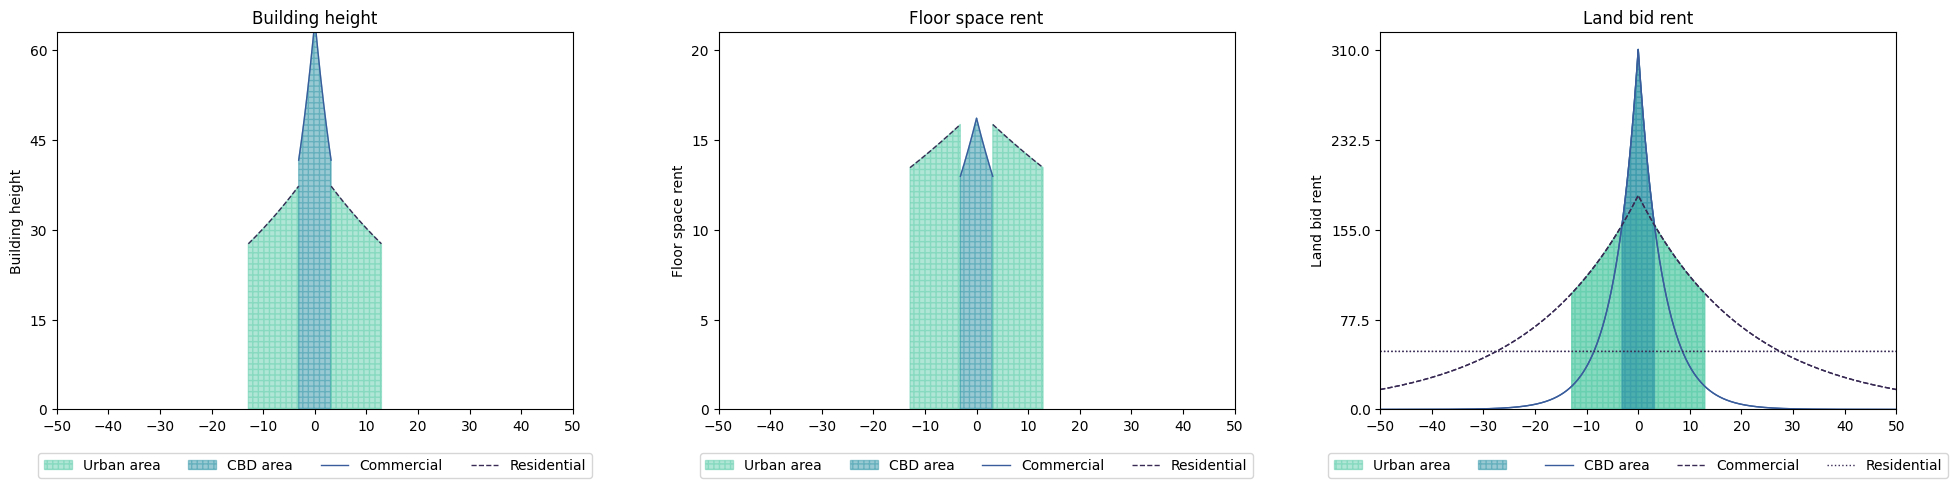

In [152]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

GHEIGHTB(df=df, ax=axes[0])
GBIDRENT(df=df, ax=axes[1])
GLANDRENT(df=df, ax=axes[2])

plt.tight_layout()

### Height Restriction

In [153]:
# Custom parameters for height limit simulation
params_height_limit = {
    'theta_C': 0.5,
    'theta_R': 0.55,
    'omega_C': 0.03,
    'omega_R': 0.07,
    'beta_C': 0.030,
    'a_bar_C': 2,
    'a_bar_R': 1,
    'tau_C': 0.01,
    'tau_R': 0.005,
    'c_C': 1.3,
    'c_R': 1.3, # Increae urban area
    'r_a': 50,
    'S_bar_C': 50,
    'S_bar_R': 50, 
}

df, params, L_hat_demand, L_hat_supply = FINDEQ(custom_params=params_height_limit)

internal objective  26320092258.249  external objective  26320092258.249
internal objective  1.0  external objective  1.0
internal objective  30811794356.314  external objective  30811794356.314
internal objective  1.0  external objective  1.0
internal objective  35623707295.902  external objective  35623707295.902
internal objective  1.0  external objective  1.0
internal objective  40796553293.687  external objective  40796553293.687
internal objective  1.0  external objective  1.0
internal objective  46373401045.879  external objective  46373401045.879
internal objective  1.0  external objective  1.0
internal objective  52345931252.666  external objective  52345931252.666
internal objective  0.891  external objective  0.891
internal objective  0.354  external objective  0.354
internal objective  0.186  external objective  0.186
internal objective  0.093  external objective  0.093
internal objective  0.047  external objective  0.047
internal objective  0.023  external objective  0.023

In [154]:
# df = pd.read_stata('/Users/dominik.bursy/Documents/8_PhD/2_Second_Year/qse_collaboration/notebooks/Stata_Output.dta')
# df['U'].value_counts()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

GHEIGHTB(df=df, ax=axes[0])
GBIDRENT(df=df, ax=axes[1])
GLANDRENT(df=df, ax=axes[2])

plt.tight_layout()

---

## References <a class="anchor" id="references"></a>

- [GitHub AHS2023-toolkit](#https://github.com/Ahlfeldt/AHS2023-toolkit/tree/main/APPLICATIONS/DATA/OUTPUT)
- [https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file](#https://github.com/Ahlfeldt/AABPL-toolkit-python?tab=readme-ov-file)
- ...

---